# 1. 데이터 로드

### 주요 import 할것들 미리 해두기 (나머지는 그때그때)

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

from tqdm.notebook import tqdm

In [2]:
import utils

### 경로 등 global config 설정

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

### 각종 데이터 불러오기

In [4]:
%%time
_, _, _, df_sub_raw = utils.load_raw(RAW_ROOT)

CPU times: user 12.9 s, sys: 6.37 s, total: 19.3 s
Wall time: 22.5 s


In [5]:
%%time
df_user_CV = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_CV.pq')
df_user_LB = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_LB.pq')
df_item_CV = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_CV.pq')
df_item_LB = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_LB.pq')
df_log_all = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')
df_log_CV = utils.get_df_log_of(df_log_all, 'CV')
df_log_LB = utils.get_df_log_of(df_log_all, 'LB')

CPU times: user 25.2 s, sys: 16.4 s, total: 41.6 s
Wall time: 36.8 s


In [6]:
del df_log_all

---

# 2. CV 테스트 환경 및 서브밋 테스트

### CV 테스트 정답셋

In [7]:
%%time
df_log_CV_test = df_log_CV[df_log_CV['target'] == 'test']
df_log_CV_train_valid = df_log_CV[df_log_CV['target'] != 'test']

CPU times: user 4.3 s, sys: 1.39 s, total: 5.69 s
Wall time: 5.63 s


In [8]:
uid2aiidset_CV = {}

In [9]:
%%time
for row in df_log_CV_test[['customer_id', 'article_id']].itertuples():
    _, uid, iid = row
    if uid not in uid2aiidset_CV:
        uid2aiidset_CV[uid] = set()
    uid2aiidset_CV[uid].add(iid)

CPU times: user 1.13 s, sys: 297 ms, total: 1.42 s
Wall time: 1.39 s


### 글로벌 베스트로 평가 지표 확인

In [10]:
df_iid_count_temp = df_log_CV_train_valid[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']

In [11]:
global_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

In [12]:
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    AP = utils.calc_ap(aiidset, global_popular_iids)
    APs.append(AP)
mAP = np.array(APs).mean()

In [13]:
print(f"POP_CV: {100 * mAP:.04f}%")

POP_CV: 0.5275%


In [14]:
del APs
del global_popular_iids
del df_iid_count_temp

### LB에 적용

In [15]:
df_iid_count_temp = df_log_LB[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']

In [16]:
global_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

서브밋

In [17]:
os.makedirs('data/subs', exist_ok=True)

In [18]:
sub_name = 'POP'

In [19]:
%%time
df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(global_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

CPU times: user 13.3 s, sys: 240 ms, total: 13.6 s
Wall time: 13.6 s


In [20]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}_LB.csv.gz' -m "global popular"
# gives you 0.31%

In [21]:
del df_sub_temp
del global_popular_iids
del df_iid_count_temp

---

# 3. Recent Week Popular

### CV에서 먼저 튜닝

In [22]:
last_week = df_log_CV_train_valid['week'].max()

In [23]:
week_cuts = list(range(1, last_week + 2))

In [24]:
results = []
for week_cut in tqdm(week_cuts):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - week_cut]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        AP = utils.calc_ap(aiidset, local_popular_iids)
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

In [25]:
del APs
del local_popular_iids
del df_iid_count_temp
del df_log_temp

week cut에 따른 성능 비교

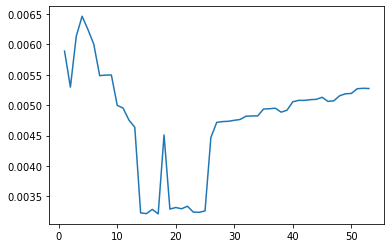

In [26]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [27]:
best_week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]

In [28]:
print(f"RWP_WC{best_week_cut}_CV: {100 * mAP:.04f}%")

RWP_WC4_CV: 0.6464%


### 이제 LB에 적용

In [29]:
last_week = df_log_LB['week'].max()

In [30]:
df_log_temp = df_log_LB[df_log_LB['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

서브밋

In [31]:
os.makedirs('data/subs', exist_ok=True)

In [32]:
sub_name = f'RWP_WC{best_week_cut}'
sub_name

'RWP_WC4'

In [33]:
%%time
df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(local_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

CPU times: user 12.8 s, sys: 68.1 ms, total: 12.9 s
Wall time: 12.9 s


In [34]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}_LB.csv.gz' -m "recent week popular tuned"
# best_week_cut == 1 gives you 0.71%
# best_week_cut == 3 gives you 0.54%
# best_week_cut == 4 gives you ?.??%
# best_week_cut == 7 gives you 0.54%

In [35]:
del df_sub_temp
del local_popular_iids
del df_iid_count_temp
del df_log_temp

---

# 4. Ascending Week Popular

### CV에서 먼저 튜닝

In [36]:
last_week = df_log_CV_train_valid['week'].max()
min_week = df_log_CV_train_valid['week'].min()

In [37]:
df_item_temp = df_item_CV.copy()
for week in tqdm(list(range(last_week + 1))):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] == week]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = [f'week_{week}_count']
    df_item_temp = df_item_temp.merge(df_iid_count_temp, how='left', left_index=True, right_index=True)
    df_item_temp[f'week_{week}_count'].fillna(0, inplace=True)

In [38]:
def ascender(weight, power, ss):
    return np.power(weight, power) * ss

In [39]:
week_cuts = list(range(2, last_week - min_week + 2))

In [40]:
powers = [i / 10 for i in range(1, 10)] + [i / 2 for i in range(2, 20)] + [i * 10 for i in range(1, 6)] + [100]
powers = [float(power) for power in powers]

In [41]:
results = []
for week_cut in tqdm(week_cuts):
    mAPs = []
    for power in powers:
        df_item_temp['awp'] = 0
        start_week = last_week - week_cut + 1
        for week in range(start_week, last_week + 1):
            weight = (week - start_week + 1) / (last_week - start_week + 2)
            df_item_temp['awp'] += ascender(weight, power, df_item_temp[f'week_{week}_count'])
        ascending_popular_iids = list(df_item_temp['awp'].sort_values(ascending=False).iloc[:12].index)
        APs = []
        for uid, aiidset in uid2aiidset_CV.items():
            AP = utils.calc_ap(aiidset, ascending_popular_iids)
            APs.append(AP)
        mAP = np.array(APs).mean()
        mAPs.append(mAP)
    best_power_index = np.argsort(mAPs)[::-1][0]
    results.append((best_power_index, mAPs[best_power_index]))

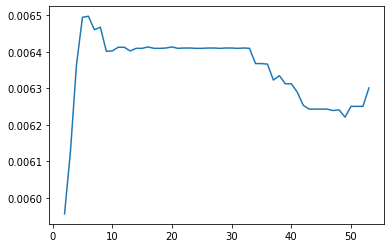

In [42]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [43]:
best_week_cut_index = np.argsort([mAP for _, mAP in results])[-1]
best_power_index, mAP = results[best_week_cut_index]
best_week_cut = week_cuts[best_week_cut_index]
best_power = powers[best_power_index]

In [44]:
print(f"AWP_WC{best_week_cut}_P{best_power}_CV: {100 * mAP:.04f}%")

AWP_WC6_P0.8_CV: 0.6497%


In [45]:
del results
del APs
del mAPs
del ascending_popular_iids

In [46]:
del df_item_temp
del df_log_temp
del df_iid_count_temp

### 이제 LB에 적용

In [47]:
last_week = df_log_LB['week'].max()

In [48]:
start_week = last_week - best_week_cut + 1

In [49]:
%%time
df_item_temp = df_item_LB.copy()
for week in range(start_week, last_week + 1):
    df_log_temp = df_log_LB[df_log_LB['week'] == week]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = [f'week_{week}_count']
    df_item_temp = df_item_temp.merge(df_iid_count_temp, how='left', left_index=True, right_index=True)
    df_item_temp[f'week_{week}_count'].fillna(0, inplace=True)

CPU times: user 1.02 s, sys: 18.8 ms, total: 1.04 s
Wall time: 803 ms


In [50]:
df_item_temp['awp'] = 0
for week in range(start_week, last_week + 1):
    weight = (week - min_week + 1) / (last_week - min_week + 2)
    df_item_temp['awp'] += ascender(weight, power, df_item_temp[f'week_{week}_count'])
ascending_popular_iids = list(df_item_temp['awp'].sort_values(ascending=False).iloc[:12].index)

서브밋

In [51]:
os.makedirs('data/subs', exist_ok=True)

In [52]:
sub_name = f'AWP_WC{best_week_cut}_P{best_power}'
sub_name

'AWP_WC6_P0.8'

In [53]:
%%time
df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(ascending_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

CPU times: user 13.2 s, sys: 96.2 ms, total: 13.2 s
Wall time: 13.4 s


In [54]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}_LB.csv.gz' -m "ascending week popular tuned"
# WC6 P0.8 gives you 0.25%
# WC7 P1.0 gives you 0.57%

In [55]:
del df_sub_temp
del ascending_popular_iids

In [56]:
del df_item_temp
del df_iid_count_temp
del df_log_temp

---

# 5. New Items

### CV에서 먼저 튜닝

garment별로 뽑아봅시다. 분포부터 확인

In [57]:
%%time
df_log_with_garment = df_log_CV.merge(df_item_CV[['garment_group_no']], how='left', left_on='article_id', right_index=True)

CPU times: user 3.81 s, sys: 851 ms, total: 4.66 s
Wall time: 4.65 s


<AxesSubplot:ylabel='garment_group_no'>

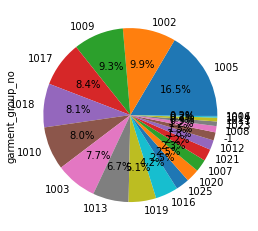

In [58]:
df_log_with_garment['garment_group_no'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [59]:
ss_garment_count = df_log_with_garment['garment_group_no'].value_counts().drop(index=[-1])
ss_garment_dist = ss_garment_count / ss_garment_count.sum()

In [60]:
del ss_garment_count
del df_log_with_garment

In [61]:
(ss_garment_dist * 12)[:12]

1005    2.011556
1002    1.201807
1009    1.136576
1017    1.029486
1018    0.989822
1010    0.980308
1003    0.936915
1013    0.812032
1019    0.623213
1016    0.513673
1025    0.304939
1020    0.300435
Name: garment_group_no, dtype: float64

적당히 갯수 배분하겠음

In [62]:
gid2quota = round(ss_garment_dist * 12)[:11].to_dict()
for gid in gid2quota:
    gid2quota[gid] = int(max(1, gid2quota[gid]))
print(sum(gid2quota.values()))

12


In [63]:
del ss_garment_dist

In [64]:
%%time
new_iids = df_log_CV[df_log_CV['target'] == 'test']['article_id'].to_list()
df_item_temp = df_item_CV[(df_item_CV['is_new'] == 1) & df_item_CV.index.isin(new_iids)]

CPU times: user 1.06 s, sys: 11.4 ms, total: 1.07 s
Wall time: 1.06 s


In [65]:
new_popular_iids = []
for gid, quota in gid2quota.items():
    rows = df_item_temp[df_item_temp['garment_group_no'] == gid].iloc[-quota:]
    iids = rows.index.to_list()[::-1]
    new_popular_iids.extend(iids)

In [66]:
%%time
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    AP = utils.calc_ap(aiidset, new_popular_iids)
    APs.append(AP)
mAP = np.array(APs).mean()

CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 158 ms


In [67]:
print(f"NEW_GARMENT_CV: {100 * mAP:.04f}%")

NEW_GARMENT_CV: 0.0175%


In [68]:
new_popular_iids = df_item_temp.index.to_list()[:12]

In [69]:
%%time
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    AP = utils.calc_ap(aiidset, new_popular_iids)
    APs.append(AP)
mAP = np.array(APs).mean()

CPU times: user 161 ms, sys: 76 µs, total: 161 ms
Wall time: 160 ms


In [70]:
print(f"NEW_ASCENDING_CV: {100 * mAP:.04f}%")

NEW_ASCENDING_CV: 0.0015%


In [71]:
new_popular_iids = df_item_temp.index.to_list()[-12:]

In [72]:
%%time
APs = []
for uid, aiidset in uid2aiidset_CV.items():
    AP = utils.calc_ap(aiidset, new_popular_iids)
    APs.append(AP)
mAP = np.array(APs).mean()

CPU times: user 159 ms, sys: 4.27 ms, total: 163 ms
Wall time: 162 ms


In [73]:
print(f"NEW_DESCENDING_CV: {100 * mAP:.04f}%")

NEW_DESCENDING_CV: 0.0077%


In [74]:
del APs
del new_popular_iids
del df_item_temp

이걸 어쩌지?? 그래도 LB에서 해볼까말까...

딱 한번만 해보자...

### LB에서 적용

In [75]:
%%time
df_log_with_garment = df_log_LB.merge(df_item_LB[['garment_group_no']], how='left', left_on='article_id', right_index=True)

CPU times: user 3.29 s, sys: 708 ms, total: 4 s
Wall time: 3.99 s


<AxesSubplot:ylabel='garment_group_no'>

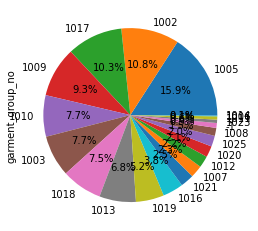

In [76]:
df_log_with_garment['garment_group_no'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [77]:
ss_garment_count = df_log_with_garment['garment_group_no'].value_counts().drop(index=[-1])
ss_garment_dist = ss_garment_count / ss_garment_count.sum()

In [78]:
del ss_garment_count
del df_log_with_garment

In [79]:
(ss_garment_dist * 12)[:12]

1005    1.923759
1002    1.305770
1017    1.252642
1009    1.127035
1010    0.931751
1003    0.931658
1018    0.913386
1013    0.822413
1019    0.634289
1016    0.463791
1021    0.304620
1007    0.274681
Name: garment_group_no, dtype: float64

적당히 갯수 배분하겠음

In [80]:
gid2quota = round(ss_garment_dist * 12)[:11].to_dict()
for gid in gid2quota:
    gid2quota[gid] = int(max(1, gid2quota[gid]))
print(sum(gid2quota.values()))

12


In [81]:
del ss_garment_dist

In [82]:
%%time
new_iids = set(df_item_LB.index.to_list()) - set(df_log_LB['article_id'].unique())
df_item_temp = df_item_LB[(df_item_LB['is_new'] == 1) & df_item_LB.index.isin(new_iids)]

CPU times: user 1.21 s, sys: 52.7 ms, total: 1.27 s
Wall time: 1.26 s


In [83]:
new_popular_iids = []
for gid, quota in gid2quota.items():
    rows = df_item_temp[df_item_temp['garment_group_no'] == gid].iloc[-quota:]
    iids = rows.index.to_list()[::-1]
    new_popular_iids.extend(iids)

서브밋

In [84]:
os.makedirs('data/subs', exist_ok=True)

In [85]:
sub_name = 'NEW_GARMENT'
sub_name

'NEW_GARMENT'

In [86]:
%%time
df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(new_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

CPU times: user 13 s, sys: 48.6 ms, total: 13.1 s
Wall time: 13.1 s


In [87]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}_LB.csv.gz' -m "new items per garment"
# gives you 0.03%

In [88]:
del df_sub_temp
del new_popular_iids
del df_item_temp

---

# 6. Recent Bought

### CV에서 튜닝?

baseline부터 준비. 4-week best로.

In [89]:
best_week_cut = 4

In [90]:
last_week = df_log_CV_train_valid['week'].max()

In [91]:
df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

In [92]:
del df_iid_count_temp
del df_log_temp

하나씩 전부 해보기. 근데 진짜 다 하진 말구... 1 ~ 20 정도만

In [93]:
max_week_cut = 20
week_cuts = list(range(1, max_week_cut + 1))

In [94]:
results = []
for week_cut in tqdm(list(range(1, max_week_cut + 1))):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > (last_week - week_cut)]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
    df_log_temp = df_log_temp.sort_values(['t_dat', 'count'], ascending=[False, False])
    df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
    df_recent_boughts.columns = ['recent_boughts']
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        predictions = []
        try:
            recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
        except KeyError:
            recent_bought_iids = []
        for iid in recent_bought_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        for iid in local_popular_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        AP = utils.calc_ap(aiidset, predictions[:12])
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

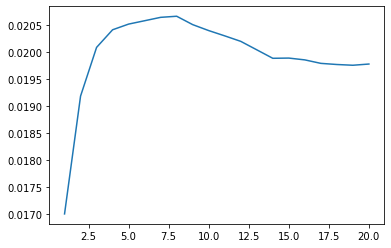

In [95]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [96]:
week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]

In [97]:
print(f"RB_WC{week_cut}_CV: {100 * mAP:.04f}%")

RB_WC8_CV: 2.0657%


In [98]:
del results
del APs
del df_recent_boughts
del recent_bought_iids
del local_popular_iids

In [99]:
del df_iid_count_temp
del df_log_temp

### LB에 적용

baseline부터 준비. 1-week best로.

In [100]:
best_week_cut = 1

In [101]:
last_week = df_log_LB['week'].max()

In [102]:
df_log_temp = df_log_LB[df_log_LB['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

In [103]:
del df_iid_count_temp
del df_log_temp

CV에선 8이 best라고는 하는데... 1, 3, 7까지 다 해보는게 좋으려나;

In [104]:
week_diff = 8

In [105]:
%%time
df_log_temp = df_log_LB[df_log_LB['week'] > (last_week - week_diff)]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
df_log_temp = df_log_temp.sort_values(['t_dat', 'count'], ascending=[False, False])
df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
df_recent_boughts.columns = ['recent_boughts']

CPU times: user 5.97 s, sys: 169 ms, total: 6.14 s
Wall time: 6.1 s


인퍼런스

In [106]:
%%time
df_sub_temp = df_sub_raw.copy()

CPU times: user 36.3 ms, sys: 39.7 ms, total: 76 ms
Wall time: 74.4 ms


In [107]:
sub_rows = []
uids = df_sub_temp['customer_id'].to_list()
for uid in tqdm(uids):
    predictions = []
    try:
        recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
    except KeyError:
        recent_bought_iids = []
    for iid in recent_bought_iids:
        if iid in predictions:
            continue
        predictions.append(iid)
    for iid in local_popular_iids:
        if iid in predictions:
            continue
        predictions.append(iid)
    sub_rows.append((uid, ' '.join(predictions[:12])))

서브밋

In [108]:
os.makedirs('data/subs', exist_ok=True)

In [109]:
sub_name = f'RB_WD{week_diff}'
sub_name

'RB_WD8'

In [110]:
%%time
df_sub_temp = pd.DataFrame(sub_rows)
df_sub_temp.columns = ['customer_id', 'prediction']
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

CPU times: user 18.9 s, sys: 136 ms, total: 19 s
Wall time: 19 s


In [111]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}_LB.csv.gz' -m "recent bought"
# WD8 gives you 2.18%
# WD3 gives you 2.16%
# WD1 gives you 1.85%

In [112]:
del df_recent_boughts
del recent_bought_iids
del local_popular_iids

In [113]:
del df_iid_count_temp
del df_log_temp

---

# 7. Recent Bought 에서 Cold 빼기

### CV에서 튜닝?

baseline부터 준비. 4-week best로.

In [114]:
best_week_cut = 4

In [115]:
last_week = df_log_CV_train_valid['week'].max()

In [116]:
df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

In [117]:
del df_iid_count_temp
del df_log_temp

하나씩 전부 해보기. 1 ~ 20 정도만

count 할때는 cold user 데이터를 쓰지만, cold user 들한텐 recent boughts를 주지 않음

In [118]:
max_week_cut = 20
week_cuts = list(range(1, max_week_cut + 1))

In [119]:
results = []
for week_cut in tqdm(week_cuts):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > (last_week - week_cut)]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
    df_log_temp = df_log_temp.merge(df_user_CV['is_cold'], how='left', left_on='customer_id', right_index=True)
    df_log_temp = df_log_temp[df_log_temp['is_cold'] == 0]
    df_log_temp = df_log_temp.sort_values(['t_dat', 'count'], ascending=[False, False])
    df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
    df_recent_boughts.columns = ['recent_boughts']
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        predictions = []
        try:
            recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
        except KeyError:
            recent_bought_iids = []
        for iid in recent_bought_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        for iid in local_popular_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        AP = utils.calc_ap(aiidset, predictions[:12])
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

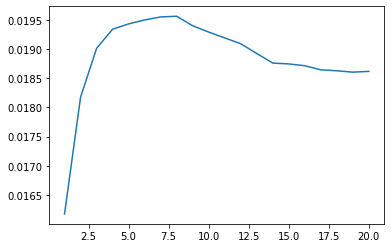

In [120]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [121]:
week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]

In [122]:
print(f"RBC_WC{week_cut}_CV: {100 * mAP:.04f}%")

RBC_WC8_CV: 1.9564%


In [123]:
del results
del APs
del df_recent_boughts
del recent_bought_iids
del local_popular_iids

In [124]:
del df_iid_count_temp
del df_log_temp

걍 하지 말자... 그래...

---

# 8. Recent Bought을 Global로 정렬하기

### CV에서 튜닝?

baseline부터 준비. 4-week best로.

In [125]:
best_week_cut = 4

In [126]:
last_week = df_log_CV_train_valid['week'].max()

In [127]:
df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

In [128]:
del df_iid_count_temp
del df_log_temp

하나씩 전부 해보기. 1 ~ 20 정도만

정렬 기준으로 count만 사용

In [129]:
max_week_cut = 20
week_cuts = list(range(1, max_week_cut + 1))

In [130]:
results = []
for week_cut in tqdm(week_cuts):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > (last_week - week_cut)]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
    df_log_temp = df_log_temp.merge(df_user_CV['is_cold'], how='left', left_on='customer_id', right_index=True)
    df_log_temp = df_log_temp[df_log_temp['is_cold'] == 0]
    df_log_temp = df_log_temp.sort_values('count', ascending=False)
    df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
    df_recent_boughts.columns = ['recent_boughts']
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        predictions = []
        try:
            recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
        except KeyError:
            recent_bought_iids = []
        for iid in recent_bought_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        for iid in local_popular_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        AP = utils.calc_ap(aiidset, predictions[:12])
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

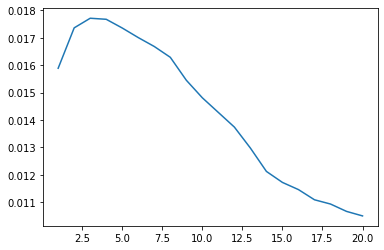

In [131]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [132]:
week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]

In [133]:
print(f"RBG_WC{week_cut}_CV: {100 * mAP:.04f}%")

RBG_WC3_CV: 1.7715%


In [134]:
del results
del APs
del df_recent_boughts
del recent_bought_iids
del local_popular_iids

In [135]:
del df_iid_count_temp
del df_log_temp

버려

---

In [136]:
del df_user_CV
del df_user_LB
del df_item_CV
del df_item_LB
del df_log_CV
del df_log_LB